<a href="https://colab.research.google.com/github/ZhangYHe/MyColabDL_Repo/blob/main/mxnet%E9%A3%8E%E6%A0%BC%E8%BF%81%E7%A7%BB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l
# !pip install -U mxnet-cu101==1.7.0
# !pip install matplotlib == 3.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/d2l-ai/d2l-zh (to revision release) to /tmp/pip-req-build-a279k1h7
  Running command git clone -q https://github.com/d2l-ai/d2l-zh /tmp/pip-req-build-a279k1h7
  Running command git checkout -b release --track origin/release
  Switched to a new branch 'release'
  Branch 'release' set up to track remote branch 'release' from 'origin'.
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 15.7 MB 5.0 MB/s 
     |████████████████████████████████| 11.2 MB 40.6 MB/s 
     |████████████████████████████████| 61 kB 7.5 MB/s 
     |████████████████████████████████| 9.9 MB 27.1 MB/s 
     |████████████████████████████████| 930 kB 43.6 MB/s 
  Created wheel for d2l: filename=d2l-2.0.0b0-py3-none-any.whl size=80152 sha256=f533223d24be47a1d992e462cdf3c284ab43e4c316a392ebce808a052da08f44
  Stored in directory: /tmp/pip-ephem-whe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |███████████████████████████████▌| 834.1 MB 1.4 MB/s eta 0:00:09tcmalloc: large alloc 1147494400 bytes == 0x3a04c000 @  0x7f1589790615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |████████████████████████████████| 846.0 MB 18 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
ERROR: Invalid requirement: '=='


In [7]:
#%matplotlib inline
from mxnet import autograd, gluon, image, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l
import matplotlib.pyplot as plt

npx.set_np()

#导入内容图和风格图
content_img = image.imread('content.jpg')
style_img = image.imread('style.jpg')

In [ ]:
rgb_mean = np.array([0.485, 0.456, 0.406])
rgb_std = np.array([0.229, 0.224, 0.225])

#预处理，将图片RGB通道做标准化
def preprocess(img, image_shape):
    img = image.imresize(img, *image_shape)
    img = (img.astype('float32') / 255 - rgb_mean) / rgb_std
    return np.expand_dims(img.transpose(2, 0, 1), axis=0)

#后处理，将输出还原为图片原始格式
def postprocess(img):
    img = img[0].as_in_ctx(rgb_std.ctx)
    return (img.transpose(1, 2, 0) * rgb_std + rgb_mean).clip(0, 1)


# def postprocess(image):# 后处理图像
#     new_image=(image.transpose((1, 2, 0)) * rgb_std + rgb_mean).clip(0, 1)
#     new_image=(new_image*255).asnumpy().astype(np.uint8)
#     return new_image


In [ ]:
#使用预训练的VGG-19网络进行特征提取
pretrained_net = gluon.model_zoo.vision.vgg19(pretrained=True)

#选取风格层和内容层
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

net = nn.Sequential()
for i in range(max(content_layers + style_layers) + 1):
    net.add(pretrained_net.features[i])

In [ ]:
#保留每一层的输出
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

In [ ]:
#进行内容特征提取
def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).copyto(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

#进行风格特征提取
def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).copyto(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

In [ ]:
#内容损失为合成图与内容图平方损失
def content_loss(Y_hat, Y):
    return np.square(Y_hat - Y).mean()

#计算格拉姆矩阵
def gram(X):
    num_channels, n = X.shape[1], d2l.size(X) // X.shape[1]
    X = X.reshape((num_channels, n))
    return np.dot(X, X.T) / (num_channels * n)

#计算风格损失
def style_loss(Y_hat, gram_Y):
    return np.square(gram(Y_hat) - gram_Y).mean()

#计算tv损失
def tv_loss(Y_hat):
    return 0.5 * (np.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  np.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

#给定每种损失所占比重    
content_weight, style_weight, tv_weight = 1, 1e3, 10

#总损失函数
def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # 对所有损失求和
    l = sum(10 * styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

In [ ]:
#初始化合成图像
class SynthesizedImage(nn.Block):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = self.params.get('weight', shape=img_shape)

    def forward(self):
        return self.weight.data()

In [ ]:
#进行初始化，计算每个风格层格拉姆矩阵
def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape)
    gen_img.initialize(init.Constant(X), ctx=device, force_reinit=True)
    trainer = gluon.Trainer(gen_img.collect_params(), 'adam',
                            {'learning_rate': lr})
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

In [ ]:
#模型训练
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs], ylim=[0, 20],
                            legend=['content', 'style', 'TV'],
                            ncols=2, figsize=(7, 2.5))
    for epoch in range(num_epochs):
        with autograd.record():
            contents_Y_hat, styles_Y_hat = extract_features(
                X, content_layers, style_layers)
            contents_l, styles_l, tv_l, l = compute_loss(
                X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step(1)
        if (epoch + 1) % lr_decay_epoch == 0:
            trainer.set_learning_rate(trainer.learning_rate * 0.8)
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X).asnumpy())
            animator.add(epoch + 1, [float(sum(contents_l)),
                                     float(sum(styles_l)), float(tv_l)])
    return X

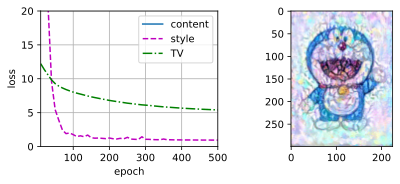

In [ ]:
#图片尺寸与内容图尺寸相同
device, image_shape = d2l.try_gpu(), (225, 300)
net.collect_params().reset_ctx(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.9, 500, 50)

In [8]:
# d2l.plt.imshow(postprocess(output).asnumpy())
# d2l.plt.imsave('out.jpg', postprocess(output).asnumpy())

NameError: ignored

In [ ]:
# import matplotlib as plt
# output = postprocess(output)
# # 显示图像
# plt.imshow(output)
# plt.show()


In [ ]:
# # !pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l
# # !pip install -U mxnet-cu101==1.7.0
# # !pip install matplotlib == 3.1.1

# #%matplotlib inline
# from mxnet import autograd, gluon, image, init, np, npx
# from mxnet.gluon import nn
# from d2l import mxnet as d2l
# import matplotlib.pyplot as plt

# npx.set_np()

# #导入内容图和风格图
# content_img = image.imread('content.jpg')
# style_img = image.imread('style.jpg')

# rgb_mean_imgnet = np.array([0.485, 0.456, 0.406])
# rgb_std_imgnet = np.array([0.229, 0.224, 0.225])

# #预处理，将图片RGB通道做标准化
# def preprocess(img, image_shape):
#     img = image.imresize(img, *image_shape)
#     img = (img.astype('float32') / 255 - rgb_mean_imgnet) / rgb_std_imgnet
#     return np.expand_dims(img.transpose(2, 0, 1), axis=0)

# #后处理，将输出还原为图片原始格式
# def postprocess(img):
#     img = img[0].as_in_ctx(rgb_std_imgnet.ctx)
#     return (img.transpose(1, 2, 0) * rgb_std_imgnet + rgb_mean_imgnet).clip(0, 1)

# #使用预训练的VGG-19网络进行特征提取
# pretrained_net = gluon.model_zoo.vision.vgg19(pretrained=True)

# #选取风格层和内容层
# style_layers, content_layers = [0, 5, 10, 19, 28], [25]

# net = nn.Sequential()
# for i in range(max(content_layers + style_layers) + 1):
#     net.add(pretrained_net.features[i])

# #保留每一层的输出
# def extract_features(X, content_layers, style_layers):
#     contents = []
#     styles = []
#     for i in range(len(net)):
#         X = net[i](X)
#         if i in style_layers:
#             styles.append(X)
#         if i in content_layers:
#             contents.append(X)
#     return contents, styles

# #进行内容特征提取
# def extract_content(image_shape, device):
#     content_X = preprocess(content_img, image_shape).copyto(device)
#     contents_Y, _ = extract_features(content_X, content_layers, style_layers)
#     return content_X, contents_Y

# #进行风格特征提取
# def extract_style(image_shape, device):
#     style_X = preprocess(style_img, image_shape).copyto(device)
#     _, styles_Y = extract_features(style_X, content_layers, style_layers)
#     return style_X, styles_Y

# #内容损失为合成图与内容图平方损失
# def content_loss(Y_hat, Y):
#     return np.square(Y_hat - Y).mean()

# #计算格拉姆矩阵
# def gram(X):
#     num_channels, n = X.shape[1], d2l.size(X) // X.shape[1]
#     X = X.reshape((num_channels, n))
#     return np.dot(X, X.T) / (num_channels * n)

# #计算风格损失
# def style_loss(Y_hat, gram_Y):
#     return np.square(gram(Y_hat) - gram_Y).mean()

# #计算tv损失
# def tv_loss(Y_hat):
#     return 0.5 * (np.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
#                   np.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

# #给定每种损失所占比重    
# content_weight, style_weight, tv_weight = 1, 1e3, 10

# #总损失函数
# def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
#     contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
#         contents_Y_hat, contents_Y)]
#     styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
#         styles_Y_hat, styles_Y_gram)]
#     tv_l = tv_loss(X) * tv_weight
#     # 对所有损失求和
#     l = sum(10 * styles_l + contents_l + [tv_l])
#     return contents_l, styles_l, tv_l, l

# #初始化合成图像
# class SynthesizedImage(nn.Block):
#     def __init__(self, img_shape, **kwargs):
#         super(SynthesizedImage, self).__init__(**kwargs)
#         self.weight = self.params.get('weight', shape=img_shape)

#     def forward(self):
#         return self.weight.data()

# #进行初始化，计算每个风格层格拉姆矩阵
# def get_inits(X, device, lr, styles_Y):
#     gen_img = SynthesizedImage(X.shape)
#     gen_img.initialize(init.Constant(X), ctx=device, force_reinit=True)
#     trainer = gluon.Trainer(gen_img.collect_params(), 'adam',
#                             {'learning_rate': lr})
#     styles_Y_gram = [gram(Y) for Y in styles_Y]
#     return gen_img(), styles_Y_gram, trainer

# #模型训练
# def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
#     X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
#     animator = d2l.Animator(xlabel='epoch', ylabel='loss',
#                             xlim=[10, num_epochs], ylim=[0, 20],
#                             legend=['content', 'style', 'TV'],
#                             ncols=2, figsize=(7, 2.5))
#     for epoch in range(num_epochs):
#         with autograd.record():
#             contents_Y_hat, styles_Y_hat = extract_features(
#                 X, content_layers, style_layers)
#             contents_l, styles_l, tv_l, l = compute_loss(
#                 X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
#         l.backward()
#         trainer.step(1)
#         if (epoch + 1) % lr_decay_epoch == 0:
#             trainer.set_learning_rate(trainer.learning_rate * 0.8)
#         if (epoch + 1) % 10 == 0:
#             animator.axes[1].imshow(postprocess(X).asnumpy())
#             animator.add(epoch + 1, [float(sum(contents_l)),
#                                      float(sum(styles_l)), float(tv_l)])
#     return X

# #图片尺寸与内容图尺寸相同
# device, image_shape = d2l.try_gpu(), (225, 300)
# net.collect_params().reset_ctx(device)
# content_X, contents_Y = extract_content(image_shape, device)
# _, styles_Y = extract_style(image_shape, device)
# output = train(content_X, contents_Y, styles_Y, device, 0.9, 500, 50)

